# Imports

In [1]:
from __future__ import annotations
import hotspot_utils
from hotspot_classes import Hotspot

import pandas as pd
import multiprocessing
from multiprocessing import Pool
from itertools import repeat

import matplotlib.pyplot as plt
%matplotlib widget

NUM_CORES = multiprocessing.cpu_count()

import warnings
warnings.filterwarnings("ignore")

# Read in Data

In [2]:
# This cell reads in parameters and response data from Excel files and combines them into a single dataframe
# Check cell outputs to make sure everything looks good

parameters_file = "Multi-Threshold Analysis Data" # Excel file to pull parameters from
parameters_sheet = "Suzuki Yields and Parameters" # Sheet in the Excel file to pull parameters from
parameters_start_col = 3   # 0-indexed column number where the parameters start
parameters_num_parameters = 190 # Number of parameters in the parameters file
parameters_num_responses = 450 # Number of responses/ligands in the parameters file
parameters_y_label_col = 0  # 0-indexed column number where the ligand labels are
parameters_header_rows = 0 # Number of rows to skip when reading the parameters

response_file = "Multi-Threshold Analysis Data" # Excel file to pull responses from
response_sheet = "Suzuki Yields and Parameters" # Sheet in the Excel file to pull responses from
response_num_samples = 450 # Number of samples/reactions in the response file
response_col = 1 # 0-indexed column number for the responses
response_y_label_col = 0  # 0-indexed column number where the ligand labels are
response_header_rows = 1 # Number of rows to skip when reading the responses

# If the parameters and outputs are on different sheets, you can use the following code to read them in separately

# parameters_file = "kraken descriptors" # Excel file to pull parameters from
# parameters_sheet = "DFT_data" # Sheet in the Excel file to pull parameters from
# parameters_start_col = 1   # 0-indexed column number where the parameters start
# parameters_num_parameters = 190 # Number of parameters in the parameters file
# parameters_num_responses = 1560 # Number of responses/ligands in the parameters file
# parameters_y_label_col = 0  # 0-indexed column number where the ligand labels are
# parameters_header_rows = 0 # Number of rows to skip when reading the parameters

# response_file = "Multi-Threshold Analysis Data" # Excel file to pull responses from
# response_sheet = "Reactions VI-IX" # Sheet in the Excel file to pull responses from
# response_num_samples = 100 # Number of samples/reactions in the response file
# response_col = 2 # 0-indexed column number for the responses
# response_y_label_col = 0  # 0-indexed column number where the ligand labels are
# response_header_rows = 0 # Number of rows to skip when reading the responses

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Actually start reading stuff into dataframes
parameters_df = pd.read_excel("./InputData/" + parameters_file + ".xlsx",
                              parameters_sheet,
                              header = parameters_header_rows,
                              index_col = parameters_y_label_col,
                              nrows = parameters_num_responses + 1,
                              usecols = list(range(0, (parameters_num_parameters + parameters_start_col)))
                              )
response_df = pd.read_excel("./InputData/" + response_file + ".xlsx",
                            response_sheet,
                            header = response_header_rows,
                            index_col = response_y_label_col,
                            nrows = response_num_samples,
                            usecols = list(range(0, response_col + 1))
                            )


# Drop any columns before parameters_start_col that are not the index column
parameters_columns_to_keep = [col for col in range(0, len(parameters_df.columns)) if col >= parameters_start_col-1]
parameters_df = parameters_df.iloc[:,parameters_columns_to_keep]

# Combine the two dataframes into the master dataframe
response_df.drop(response_df.columns[0:response_col-1], axis = 'columns', inplace = True)
response_df['y_class'] = 0 # This should create the "y_class" column that will ultimately be used for classification labels
data_df = response_df.merge(parameters_df, left_index = True, right_index = True)
data_df.columns.values[0] = 'response' # Converts the output column name from whatever it is on the spreadsheet
data_df.dropna(inplace = True) # This covers the entire masking section and trims the dataframe down to only the rows relevant to this dataset

# This converts all the data to numeric values since it was reading them in as non-numeric objects for some reason
for column in data_df.columns:
    data_df[column] = pd.to_numeric(data_df[column], errors='coerce')
data_df.dropna(inplace = True)

# Creates a dictionary to convert x# labels to full parameter names
x_names = list(parameters_df.iloc[0, :parameters_num_parameters])
x_labels = list(parameters_df.columns)[:parameters_num_parameters]
x_labelname_dict = dict(zip(x_labels, x_names))

# Print out some information about the dataframe to confirm it was read in correctly
print("Parameter file shape: {}".format(parameters_df.shape))
print("Final parameter quantity: {}".format(len(x_labels)))
print("Final experiment quantity: {}".format(data_df.shape[0]))
print("First parameter cell: {}".format(data_df[x_labels[0]].iloc[0]))
print("Last parameter cell:  {}".format(data_df[x_labels[-1]].iloc[-1]))
print("First response: {}".format(data_df.iloc[0,0]))
print("Last response:  {}".format(data_df.iloc[-1,0]))
print("First reaction label: {}".format(data_df.index[0]))
print("Last reaction label:  {}".format(data_df.index[-1]))

display(data_df)

Parameter file shape: (451, 190)
Final parameter quantity: 190
Final experiment quantity: 450
First parameter cell: -0.063669988
Last parameter cell:  7.650386242
First response: 1.9165341260000002
Last response:  -12.1439
First reaction label: R1_2
Last reaction label:  R5_838


,response,y_class,x1,x2,x3,x4,x5,x6,x7,x8,...,x181,x182,x183,x184,x185,x186,x187,x188,x189,x190
R1_2,1.916534,0,-0.063670,1.784157,-0.206310,-0.023277,-0.114794,0.183033,0.036033,0.061658,...,6.572514,6.339063,7.850955,1.511892,6.407769,7.285463,6.908743,8.216943,1.308200,7.992698
R1_5,98.000000,0,-0.061351,1.816461,-0.218842,-0.030145,-0.124494,0.188697,0.041069,0.060353,...,6.497622,6.092458,7.055260,0.962802,6.376705,7.370445,7.021018,8.155038,1.134020,8.086289
R1_6,0.617317,0,-0.071244,1.780166,-0.209940,0.016420,-0.096760,0.226360,0.020681,0.083040,...,6.443564,6.443564,6.443564,0.000000,6.443564,6.952513,6.952513,6.952513,0.000000,6.952513
R1_8,0.851423,0,-0.067185,1.780165,-0.216880,0.036010,-0.090435,0.252890,0.016170,0.113990,...,4.894739,4.894739,4.894739,0.000000,4.894739,6.648917,6.648917,6.648917,0.000000,6.648917
R1_10,4.908090,0,-0.067275,1.781649,-0.217025,0.020780,-0.098122,0.237805,0.020244,0.090149,...,6.615313,6.374532,7.124679,0.750147,6.377288,7.056268,7.037797,7.146163,0.108366,7.099058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R5_796,-13.206800,0,-0.024164,1.903453,-0.257967,-0.078693,-0.168330,0.179275,0.079036,0.006817,...,6.954069,6.028940,7.391170,1.362230,6.086104,6.989464,6.925771,7.430007,0.504236,7.430007
R5_797,-12.784600,0,-0.024191,1.900147,-0.256970,-0.079570,-0.168270,0.177400,0.079805,0.011430,...,6.027940,6.027940,6.029321,0.001381,6.029321,6.909132,6.909131,6.918910,0.009778,6.918910
R5_798,-13.645200,0,-0.026401,1.900154,-0.254050,-0.079880,-0.166965,0.174170,0.080029,0.005780,...,6.034069,6.029424,6.034070,0.004646,6.034070,6.910345,6.910344,6.919218,0.008874,6.910344
R5_799,-10.548200,0,-0.041824,1.902125,-0.234732,-0.074462,-0.154597,0.160270,0.074580,0.027824,...,6.041513,6.039198,6.050017,0.010818,6.039198,6.954143,6.941776,6.999585,0.057808,6.941776


# Training/Test Split

Training Set: ['R1_2', 'R1_5', 'R1_6', 'R1_8', 'R1_10', 'R1_11', 'R1_12', 'R1_14', 'R1_20', 'R1_21', 'R1_22', 'R1_30', 'R1_32', 'R1_44', 'R1_53', 'R1_64', 'R1_65', 'R1_68', 'R1_70', 'R1_79', 'R1_82', 'R1_88', 'R1_89', 'R1_90', 'R1_103', 'R1_104', 'R1_117', 'R1_133', 'R1_137', 'R1_157', 'R1_158', 'R1_159', 'R1_162', 'R1_163', 'R1_165', 'R1_168', 'R1_169', 'R1_170', 'R1_171', 'R1_175', 'R1_176', 'R1_179', 'R1_180', 'R1_182', 'R1_184', 'R1_185', 'R1_186', 'R1_187', 'R1_196', 'R1_208', 'R1_233', 'R1_239', 'R1_243', 'R1_249', 'R1_251', 'R1_252', 'R1_260', 'R1_266', 'R1_276', 'R1_277', 'R1_280', 'R1_281', 'R1_292', 'R1_295', 'R1_296', 'R1_299', 'R1_303', 'R1_309', 'R1_310', 'R1_311', 'R1_314', 'R1_320', 'R1_323', 'R1_327', 'R1_337', 'R1_340', 'R1_344', 'R1_487', 'R1_566', 'R1_584', 'R1_608', 'R1_720', 'R1_735', 'R1_739', 'R1_795', 'R1_796', 'R1_797', 'R1_798', 'R1_799', 'R1_838', 'R2_2', 'R2_5', 'R2_6', 'R2_8', 'R2_10', 'R2_11', 'R2_12', 'R2_14', 'R2_20', 'R2_21', 'R2_22', 'R2_30', 'R2_32', 

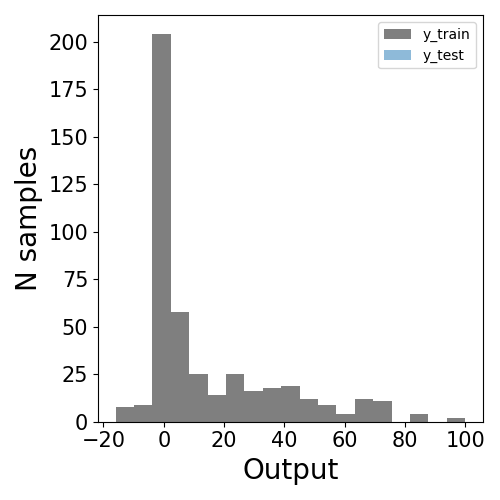

In [3]:
# Divide the data into training and test sets
# split options are 'random', 'ks' (kennard-stone), 'y_equidist' (equidistant in y), 'define' (manual selection) and 'none'
split = "none"
test_ratio = 0.3 

training_set, test_set = hotspot_utils.train_test_splits(data_df, split, test_ratio)

# Run the Combined Threshold Finder

## Automatic Threshold Analysis

Edit and run the first cell to set the parameters of the threshold analysis, then run the second cell without changing anything (unless you have a good reason to) to start the calculations.

This section automatically identifies the best hotspots/multi-thresholds based on the parameters set in the first cell.

In [4]:
# Cutoff in your output for what counts as an active ligand
y_cut = 10

# Set to True if you want points below the y-cut to be considered active
low_is_good = False

# How heavily to value active ligands (1) over inactive ligands (0)
class_weight = {1:10, 0:1} 

# How the prune_hotspots and find_best_hotspots evaluates which are the best
# Can be set to 'accuracy', 'weighted_accuracy', 'f1', and 'weighted_f1'
evaluation_method = 'weighted_accuracy'

# How many threshold dimensions do you want?
n_thresholds = 2

# What percentage of thresholds are analyzed in each subsequent step
percentage = 100

In [5]:
# Set up y_class, the binary list of which y values are above y_cut
if(low_is_good):
    for i in data_df.index:
        data_df.loc[i, 'y_class'] = int(data_df.loc[i, 'response'] < y_cut)
else:
    for i in data_df.index:
        data_df.loc[i, 'y_class'] = int(data_df.loc[i, 'response'] > y_cut)

# Find the best thresholds within the full X and y space and make single threshold hotspot objects from them
all_thresholds = hotspot_utils.threshold_generation(data_df, class_weight, evaluation_method, x_labelname_dict)
best_hotspots = []
for thresh in all_thresholds:
    temp_hs = Hotspot(data_df, [thresh], y_cut, training_set, test_set, evaluation_method, class_weight)
    best_hotspots.append(temp_hs)

# Cut down to the best {percentage} hotspots
best_hotspots = hotspot_utils.prune_hotspots(best_hotspots, percentage, evaluation_method)

# Add more thresholds, pruning after each step for resource management
for i in range(n_thresholds - 1):
    with Pool(processes=int(NUM_CORES*.7)) as p:
        new_hotspots = p.starmap(hotspot_utils.hs_next_thresholds_fast, zip(best_hotspots, repeat(all_thresholds)))
    new_hotspots = [item for sublist in new_hotspots for item in sublist] 
    
    best_hotspots = hotspot_utils.prune_hotspots(new_hotspots, percentage, evaluation_method)

best_hotspots.sort(key = lambda x: x.accuracy_dict[evaluation_method], reverse = True)

# print the top 5 hotspots
for i, hs in enumerate(best_hotspots[:5]):
    print(f'Hotspot Index: {i}')
    print(hs)
    hs.print_stats()
    print('\n**********************************\n')

Hotspot Index: 0
Total weighted_accuracy with 2 thresholds: 0.932
Initial weighted_accuracy with no thresholds: 0.847
Total accuracy with 2 thresholds: 0.793
Initial accuracy with no thresholds: 0.356
Thresholds: 
	x87 vbur_vbur_min < 57.277 with added weighted_accuracy of 0.053
	x53 dipolemoment_max < 4.373 with added weighted_accuracy of 0.032

                    all    train    test
         Accuracy: 0.793   0.793   0.000
Weighted Accuracy: 0.932   0.932   0.000
               F1: 0.770   0.770   0.000
      Weighted F1: 0.960   0.960   0.000

        Precision: 0.637
           Recall: 0.975

**********************************

Hotspot Index: 1
Total weighted_accuracy with 2 thresholds: 0.932
Initial weighted_accuracy with no thresholds: 0.847
Total accuracy with 2 thresholds: 0.793
Initial accuracy with no thresholds: 0.356
Thresholds: 
	x90 vbur_vbur_vburminconf < 57.277 with added weighted_accuracy of 0.053
	x53 dipolemoment_max < 4.373 with added weighted_accuracy of 0.032

 

## Manual Threshold Selection

Edit and run the first cell to set the parameters of the threshold analysis, then run the second cell without changing anything (unless you have a good reason to) to start the calculations.

This section allows you to manually select which feature(s) or range of features are used in the analysis.

In [6]:
# What features do you want in your hotspot?
# For ranges, use data_df.columns[x:y].to_list() to get a list of feature xIDs
# For specific features, use ['xID1', 'xID2', ...]

# manual_features = [['x1'], ['x87']]
# manual_features = [['x87']]
manual_features = [['x1'], ['x87'], data_df.columns[3:].to_list()]

# Cutoff for what counts as a hit
y_cut = 10

# How heavily to value hits (1) over misses (0)
class_weight = {1:10, 0:1} 

# What percentage of hotspots to take through to each subsequent step
# Only relevant if using ranges instead of specific parameters
percentage = 100

# How the prune_hotspots and find_best_hotspots evaluates which are the best
# Can be set to 'accuracy', 'weighted_accuracy', 'f1', and 'weighted_f1'
evaluation_method = 'weighted_accuracy'

# Set to True if you want a hotspot of low output results (cold spot?)
low_is_good = False

In [7]:
# Set up y_class, the binary list of which y values are above y_cut
if(low_is_good):
    for i in data_df.index:
        data_df.loc[i, 'y_class'] = int(data_df.loc[i, 'response'] < y_cut)
else:
    for i in data_df.index:
        data_df.loc[i, 'y_class'] = int(data_df.loc[i, 'response'] > y_cut)

# Find the best thresholds within the full X and y space and make single threshold hotspot objects from them
all_thresholds = hotspot_utils.threshold_generation(data_df, class_weight, evaluation_method, x_labelname_dict, manual_features[0])
best_hotspots = []
for thresh in all_thresholds:
    temp_hs = Hotspot(data_df, [thresh], y_cut, training_set, test_set, evaluation_method, class_weight)
    best_hotspots.append(temp_hs)

# Cut down to the best {percentage} hotspots
best_hotspots = hotspot_utils.prune_hotspots(best_hotspots, percentage, evaluation_method)

# Add more thresholds, pruning after each step for resource management
for i in range(len(manual_features) - 1):
    new_hotspots = []
    for hs in best_hotspots:
        temp_hotspots = hotspot_utils.hs_next_thresholds(hs, data_df, class_weight, x_labelname_dict, manual_features[i+1])
        new_hotspots.extend(temp_hotspots)
    best_hotspots = new_hotspots
    del (new_hotspots)
    best_hotspots = hotspot_utils.prune_hotspots(best_hotspots, percentage, evaluation_method)
    
best_hotspots.sort(key = lambda x: x.accuracy_dict[evaluation_method], reverse = True)

# print the top 5 hotspots
for i, hs in enumerate(best_hotspots[:5]):
    print(f'Hotspot Index: {i}')
    print(hs)
    hs.print_stats()
    print('\n**********************************\n')

Hotspot Index: 0
Total weighted_accuracy with 3 thresholds: 0.930
Initial weighted_accuracy with no thresholds: 0.847
Total accuracy with 3 thresholds: 0.847
Initial accuracy with no thresholds: 0.356
Thresholds: 
	x1 vmin_vmin_boltz < -0.046 with added weighted_accuracy of 0.025
	x87 vbur_vbur_min < 57.277 with added weighted_accuracy of 0.051
	x24 E_solv_cds_boltz < -2.108 with added weighted_accuracy of 0.008

                    all    train    test
         Accuracy: 0.847   0.847   0.000
Weighted Accuracy: 0.930   0.930   0.000
               F1: 0.816   0.816   0.000
      Weighted F1: 0.959   0.959   0.000

        Precision: 0.712
           Recall: 0.956

**********************************

Hotspot Index: 1
Total weighted_accuracy with 3 thresholds: 0.928
Initial weighted_accuracy with no thresholds: 0.847
Total accuracy with 3 thresholds: 0.836
Initial accuracy with no thresholds: 0.356
Thresholds: 
	x1 vmin_vmin_boltz < -0.046 with added weighted_accuracy of 0.025
	x87 vbur

# Analysis

## Print Longer List of Hotspots

This cell prints the text output for a longer list of hotspots if you want to see more than were given in the previous sections.

In [ ]:
# How many hotspots do you want listed?
n = 50

for i, hs in enumerate(best_hotspots[:n]):
    print(f'Hotspot Index: {i}')
    print(hs)
    hs.print_stats()
    print('\n**********************************\n')

## Display Individual Hotspot

For more further control over plot style, changes can be made to functions in the hotsput_utils.py file.

Total weighted_accuracy with 3 thresholds: 0.930
Initial weighted_accuracy with no thresholds: 0.847
Total accuracy with 3 thresholds: 0.847
Initial accuracy with no thresholds: 0.356
Thresholds: 
	x1 vmin_vmin_boltz < -0.046 with added weighted_accuracy of 0.025
	x87 vbur_vbur_min < 57.277 with added weighted_accuracy of 0.051
	x24 E_solv_cds_boltz < -2.108 with added weighted_accuracy of 0.008



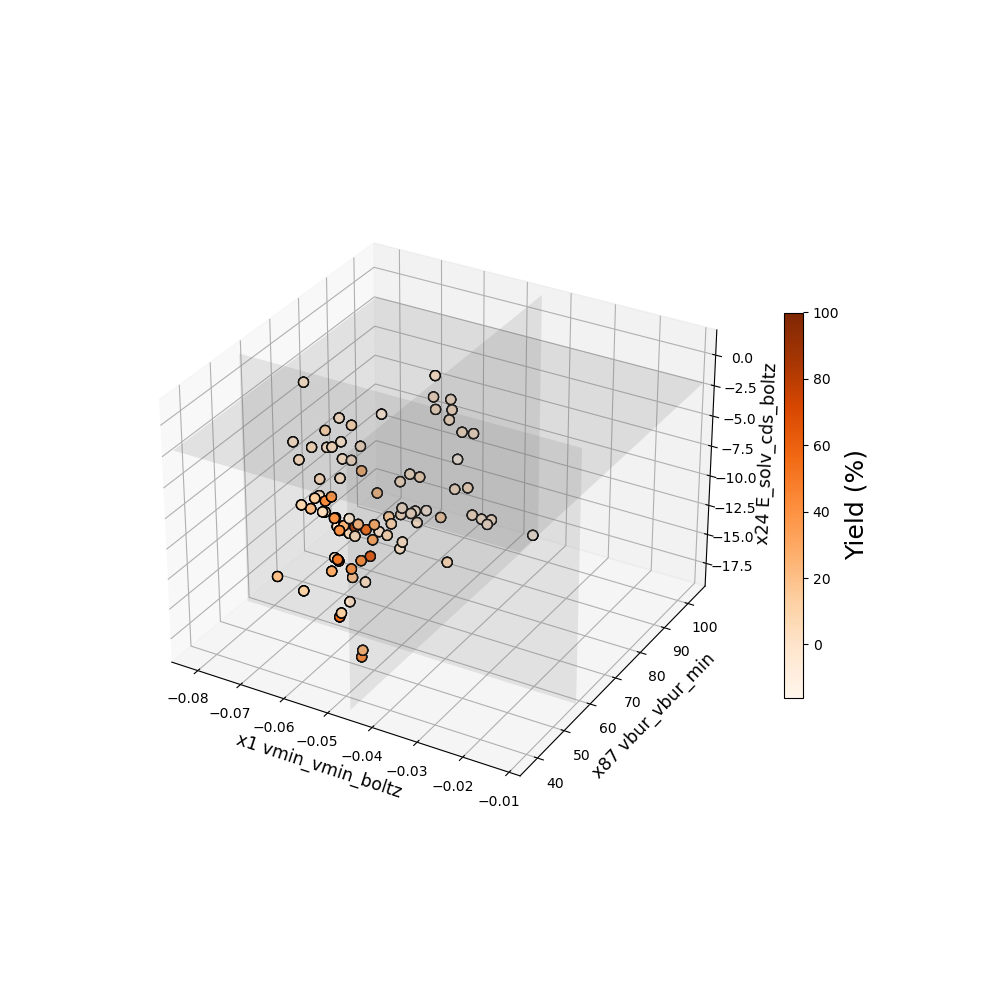

In [8]:
# Select the hotspot you want to plot based on its index
hotspot_index = 0

print(best_hotspots[hotspot_index])

# subset can be 'all', 'training', or 'test'
# You can change the coloring to either 'scaled' or 'binary'
# output_label is whatever you call your output (Only relevant when using 'scaled' coloring or single threshold)
hotspot_utils.plot_hotspot(best_hotspots[hotspot_index], subset='all', coloring='scaled', output_label='Yield (%)', gradient_color='Oranges')

# Virtual Screening / Validation

## Import Virtual Screening / Validation Parameter Data

In [9]:
# Import the parameters for the previously unseen molecules, required for both virtual screening and validation
# This assumes the excel sheet has a row of xID labels then a row of full parameter names
parameters_file = "kraken descriptors" 
parameters_sheet = "DFT_data" 
parameters_num_parameters = 190
parameters_start_col = 1   # 0-indexed
parameters_num_samples = 1560 
parameters_y_label_col = 0  # 0-indexed
parameters_header_rows = 0


# Actually start reading stuff into the parameter dataframe
vs_parameters_df = pd.read_excel("./InputData/" + parameters_file + ".xlsx",
                              parameters_sheet,
                              header = parameters_header_rows,
                              index_col = parameters_y_label_col,
                              nrows = parameters_num_samples + 1,
                              usecols = list(range(0, (parameters_num_parameters + parameters_start_col)))
                              )

# Create a dictionary to convert x# labels to full parameter names
vs_x_names = list(vs_parameters_df.iloc[0, parameters_start_col - 1 : parameters_num_parameters + parameters_start_col - 1])
vs_x_labels = list(vs_parameters_df.columns)[parameters_start_col - 1 : parameters_num_parameters + parameters_start_col - 1]
vs_x_labelname_dict = dict(zip(vs_x_labels, vs_x_names))

vs_parameters_df.drop(vs_parameters_df.index[0], inplace=True) # Remove the full parameter name row
vs_parameters_df.index = vs_parameters_df.index.astype(int) # This converts the index (molecule/reaction number) from strings to ints

# Convert all the data to numeric values since it was reading them in as non-numeric objects for some reason
for column in vs_parameters_df.columns:
    vs_parameters_df[column] = pd.to_numeric(vs_parameters_df[column], errors='coerce')

display(vs_parameters_df)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x181,x182,x183,x184,x185,x186,x187,x188,x189,x190
ID,,,,,,,,,,,,,,,,,,,,,
1,-0.061654,1.819048,-0.218243,-0.025112,-0.121678,0.193131,0.038336,0.059115,-0.363712,0.801914,...,7.439480,6.306577,7.835474,1.528897,7.262693,7.291573,7.106519,8.238802,1.132283,7.735548
2,-0.063670,1.784157,-0.206310,-0.023277,-0.114794,0.183033,0.036033,0.061658,-0.345264,0.816302,...,6.572514,6.339063,7.850955,1.511892,6.407769,7.285463,6.908743,8.216943,1.308200,7.992698
3,-0.066303,1.798595,-0.213323,-0.016923,-0.115123,0.196400,0.033750,0.069846,-0.356952,0.796412,...,7.156276,6.349086,7.287324,0.938238,7.021625,7.306643,7.025374,8.361404,1.336030,7.424874
4,-0.067319,1.795292,-0.211571,-0.013802,-0.112687,0.197770,0.032124,0.070775,-0.349017,0.798225,...,7.238774,6.369287,7.813010,1.443723,7.653520,7.338674,6.996319,8.333428,1.337110,7.483233
5,-0.061351,1.816461,-0.218842,-0.030145,-0.124494,0.188697,0.041069,0.060353,-0.376125,0.787516,...,6.497622,6.092458,7.055260,0.962802,6.376705,7.370445,7.021018,8.155038,1.134020,8.086289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,-0.030190,1.897296,-0.201110,-0.032170,-0.116640,0.168940,0.040266,0.062260,-0.365380,1.232069,...,5.154585,5.154583,5.564756,0.410173,5.154583,7.436052,7.436049,8.184145,0.748096,7.436049
1906,-0.069225,1.740571,-0.175289,-0.001523,-0.088406,0.173766,0.022500,0.078390,-0.332374,0.807100,...,7.475374,6.863757,8.017363,1.153606,6.863757,7.396400,7.113335,8.383908,1.270572,8.383908
1907,-0.052625,1.805652,-0.209751,-0.031875,-0.120813,0.177876,0.041028,0.061741,-0.388234,1.132263,...,6.067951,6.066905,6.074041,0.007136,6.074041,8.062340,8.044172,8.168212,0.124040,8.168212


## Validation

In [10]:
# Read the validation results from the excel sheet
# The final result should be a dataframe with indicies corresponding to the vs_parameters_df from above,
# a column of experimental outputs, and all the relevant parameters

validation_file = "Multi-Threshold Analysis Data"
validation_sheet = "Reaction II Validation (2)"
validation_experimental_col = 2

############################################################################################################

vs_response_df = pd.read_excel('./InputData/' + validation_file + '.xlsx',
                              sheet_name=validation_sheet,
                              index_col=0,
                              )

# Drop all columns except the experimental output
vs_response_df = vs_response_df.iloc[:, [validation_experimental_col-1]]
vs_response_df.columns = ['response']

for column in vs_response_df.columns:
    vs_response_df[column] = pd.to_numeric(vs_response_df[column], errors='coerce')
vs_response_df.dropna(inplace = True)

vs_combined_df = pd.concat([vs_response_df, vs_parameters_df], axis=1, join='inner')

display(vs_combined_df)

,response,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x181,x182,x183,x184,x185,x186,x187,x188,x189,x190
ID,,,,,,,,,,,,,,,,,,,,,
9,1.609991,-0.043479,1.820164,-0.222589,-0.028099,-0.125344,0.194489,0.040391,0.058946,-0.384740,...,6.042971,6.042803,6.210989,0.168186,6.210989,6.778337,6.776344,7.604455,0.828112,7.604455
15,7.657939,-0.066832,1.857948,-0.208249,-0.018070,-0.113159,0.190179,0.033669,0.067763,-0.357541,...,6.040470,6.039354,6.149515,0.110161,6.149515,6.803049,6.754168,7.181257,0.427089,7.176587
16,0.000000,-0.022009,1.900156,-0.260320,-0.068780,-0.164550,0.191540,0.070682,0.017420,-0.423380,...,6.027594,6.027594,6.027594,0.000000,6.027594,6.903372,6.903372,6.903372,0.000000,6.903372
17,38.500000,-0.048230,1.860160,-0.228390,-0.029490,-0.128940,0.198900,0.041794,0.060510,-0.394380,...,6.029300,6.029300,6.029300,0.000000,6.029300,6.914110,6.914110,6.914110,0.000000,6.914110
19,62.000000,-0.048827,1.857944,-0.230260,-0.029143,-0.129701,0.201117,0.041827,0.061312,-0.379549,...,6.931442,6.054706,7.098971,1.044265,6.054706,7.246557,7.210787,7.680655,0.469868,7.680655
30,5.932400,-0.067773,1.782726,-0.216839,0.033656,-0.091591,0.250495,0.016745,0.110258,-0.431334,...,6.206572,6.095226,6.450931,0.355706,6.423808,7.083345,6.697179,7.146336,0.449158,6.707379
31,2.319564,-0.062160,1.782107,-0.225350,-0.025040,-0.125195,0.200310,0.039124,0.080490,-0.404680,...,6.029335,6.029335,6.029335,0.000000,6.029335,7.042766,7.042766,7.042766,0.000000,7.042766
32,10.685827,-0.066850,1.781811,-0.219145,0.032404,-0.093370,0.251549,0.017330,0.106745,-0.426158,...,6.366421,6.092568,6.462962,0.370394,6.142229,7.120917,6.530565,7.187778,0.657212,6.971933
53,0.500000,-0.081156,1.834348,-0.189637,-0.008817,-0.099227,0.180820,0.027235,0.073212,-0.335489,...,6.178911,6.160660,6.214017,0.053357,6.208167,6.875523,6.658546,7.703383,1.044837,7.173690


### Print/Export Validation Classifications

In [11]:
# Select hotspot to validate
hotspot_index = 0

# Set to True if you want to write the validation results to an Excel file
write_to_excel = False
output_name = 'validation_output.xlsx'

############################################################################################################

hs = best_hotspots[hotspot_index]

# Begin the output dataframe with the experimental results and the y_class column
validation_report_df = vs_response_df.copy()
validation_report_df['y_class'] = [y > hs.y_cut for y in validation_report_df.iloc[:, 0]]

# Add the parameter values and binary evaluations for each ligand to the output dataframe
# True in an xID column indicates that the ligand is predicted to be active by that threshold
for parameter in hs.threshold_indexes:
    validation_report_df[f'{parameter}_{vs_x_labelname_dict[parameter]}'] = vs_parameters_df.loc[validation_report_df.index, parameter]

threshold_evaluations = hs.expand(vs_parameters_df.loc[validation_report_df.index])
validation_report_df = pd.concat([validation_report_df, threshold_evaluations], axis=1)

# Create a column for the final hotspot evaluation if there is more than a single threshold
if len(hs.thresholds) > 1:
    for ligand in validation_report_df.index:
        evaluation = all([validation_report_df.loc[ligand, threshold] for threshold in hs.threshold_indexes])
        validation_report_df.loc[ligand, 'Full Hotspot Evaluation'] = evaluation

display(validation_report_df)

hs.get_external_accuracy(vs_combined_df, verbose=True)

if write_to_excel:
    validation_report_df.to_excel(output_name)

,response,y_class,x1_vmin_vmin_boltz,x87_vbur_vbur_min,x24_E_solv_cds_boltz,x1,x87,x24,Full Hotspot Evaluation
ID,,,,,,,,,
9,1.609991,False,-0.043479,61.752303,-7.679303,False,False,True,False
15,7.657939,False,-0.066832,59.366594,-4.987193,True,False,True,False
16,0.000000,False,-0.022009,50.576811,-4.070000,False,True,True,False
17,38.500000,True,-0.048230,50.688723,-7.180000,True,True,True,True
19,62.000000,True,-0.048827,47.615855,-7.654484,True,True,True,True
30,5.932400,False,-0.067773,61.557764,-5.115630,True,False,True,False
31,2.319564,False,-0.062160,63.125575,-4.690000,True,False,True,False
32,10.685827,True,-0.066850,57.520572,-6.858884,True,False,True,False
53,0.500000,False,-0.081156,73.743599,-3.322182,True,False,True,False


Accuracy: 0.92
Precision: 1.00
Recall: 0.88


### Plot Validation Results

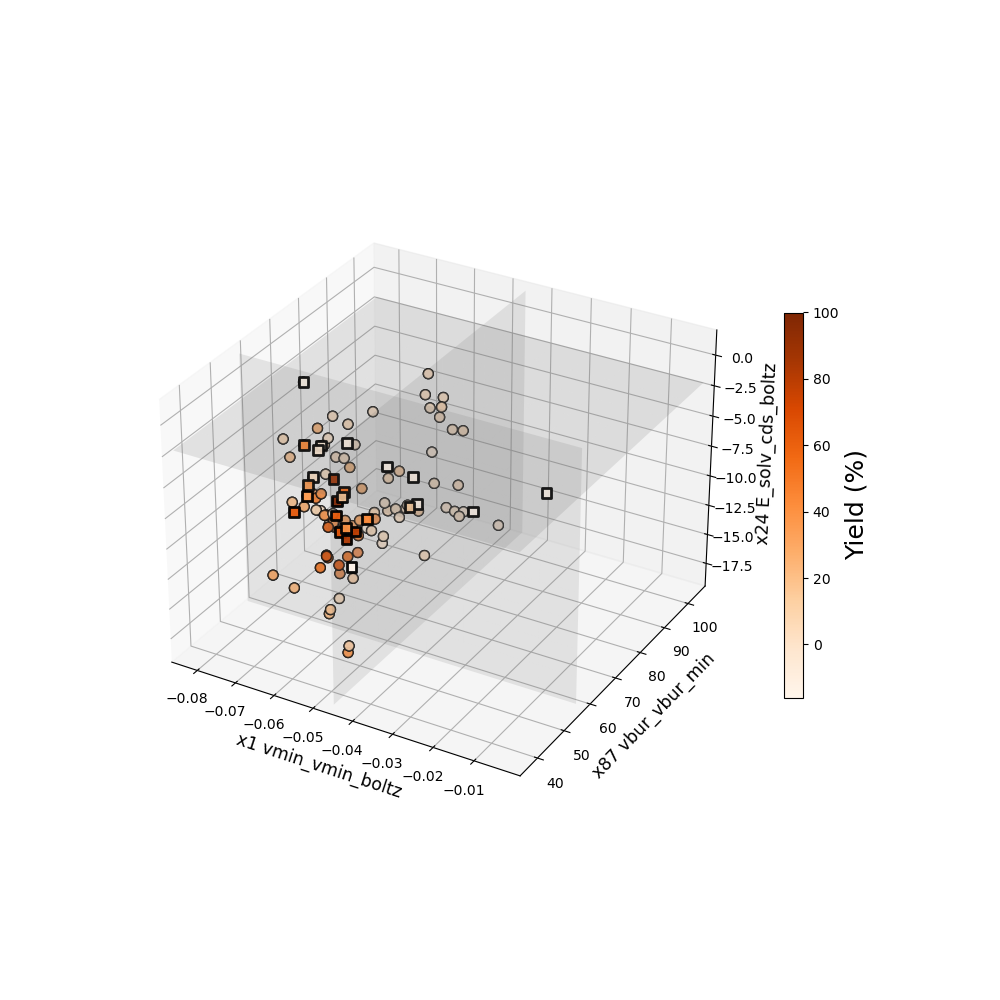

In [15]:
# Plot your validation data on the hotspot selected by hotspot_index
# Modify the last line for plotting options
hotspot_index = 0
hs = best_hotspots[hotspot_index]

# hide_training can be set to True to only plot the validation data
# You can change the coloring to either 'scaled' or 'binary'
# output_label is whatever you call your output (Only relevant when using 'scaled' coloring or single threshold)
hotspot_utils.plot_hotspot(hs, vs_response_df, vs_parameters_df, hide_training=False, coloring='scaled', output_label='Yield (%)', gradient_color='Oranges')

## Virtual Screening

,x1_vmin_vmin_boltz,x87_vbur_vbur_min,x24_E_solv_cds_boltz,x1,x87,x24,Full Hotspot Evaluation
ID,,,,,,,
1,-0.061654,56.456887,-11.780090,True,True,True,True
2,-0.063670,58.538238,-10.649541,True,False,True,False
3,-0.066303,56.874203,-8.933203,True,True,True,True
4,-0.067319,55.427717,-10.874606,True,True,True,True
5,-0.061351,57.033181,-10.363806,True,True,True,True
...,...,...,...,...,...,...,...
1905,-0.030190,49.197263,-5.800001,False,True,True,False
1906,-0.069225,73.391130,-15.051511,True,False,True,False
1907,-0.052625,61.414475,-5.016565,True,False,True,False


The plot below is meant only to show the distribution of the virtual screen since experimental data has not been supplied


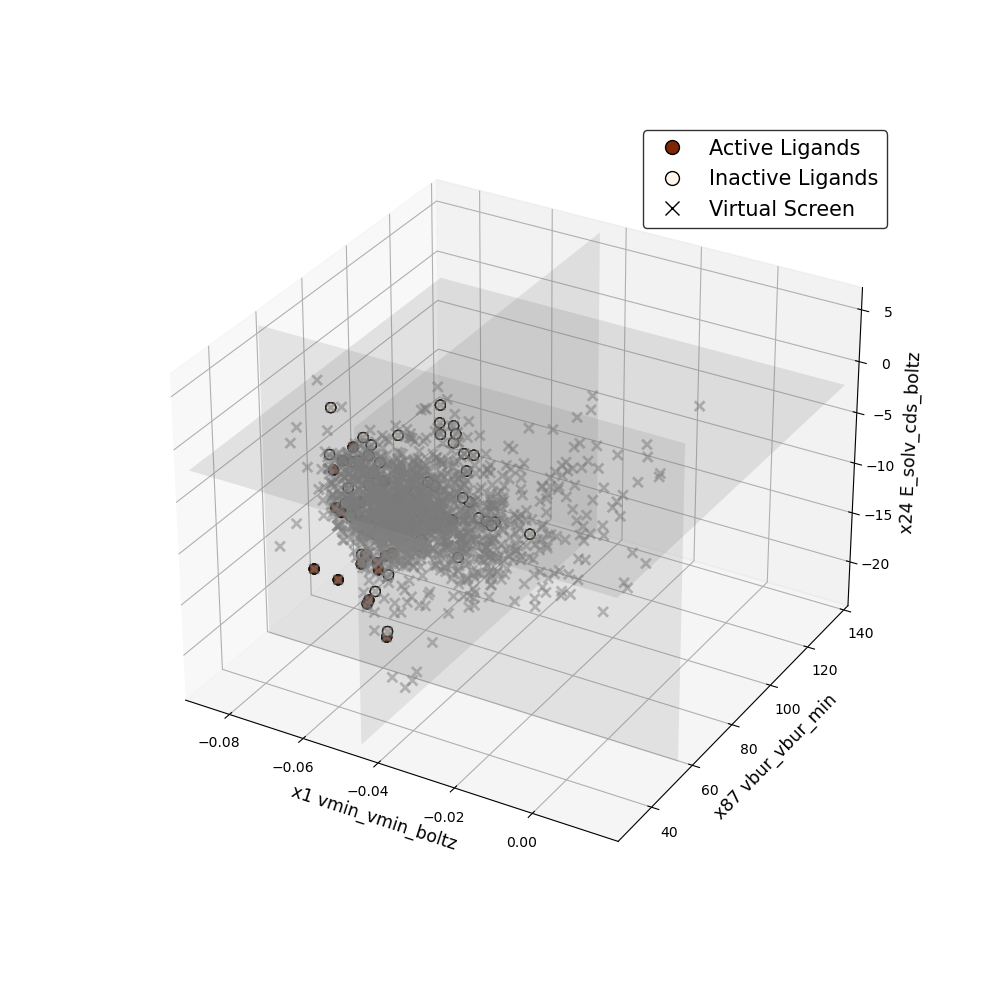

In [17]:
# Select hotspot to screen against
hotspot_index = 0

# Set to True if you want to write the virtual screen results to an Excel file
write_to_excel = True
output_name = 'virtual_screen_output.xlsx'

############################################################################################################

hs = best_hotspots[hotspot_index]

# Trim down to the parameter values relevant to this hotspot and add binary evaluations from each ligand
# True in an xID column indicates that the ligand is predicted to be active by that threshold
virtual_screen_report_df = vs_parameters_df.loc[:, hs.threshold_indexes]
virtual_screen_report_df.columns = [f'{parameter}_{vs_x_labelname_dict[parameter]}' for parameter in virtual_screen_report_df.columns]

threshold_evaluations = hs.expand(vs_parameters_df)
virtual_screen_report_df = pd.concat([virtual_screen_report_df, threshold_evaluations], axis=1)

# Create a column for the final hotspot evaluation if there is more than a single threshold
if len(hs.thresholds) > 1:
    for ligand in virtual_screen_report_df.index:
        evaluation = all([virtual_screen_report_df.loc[ligand, threshold] for threshold in hs.threshold_indexes])
        virtual_screen_report_df.loc[ligand, 'Full Hotspot Evaluation'] = evaluation

if write_to_excel:
    virtual_screen_report_df.to_excel(output_name)

display(virtual_screen_report_df)

print('The plot below is meant only to show the distribution of the virtual screen since experimental data has not been supplied')
hotspot_utils.plot_hotspot(hs, vs_parameters=vs_parameters_df, hide_training=False, coloring='binary', output_label='Yield (%)', gradient_color='Oranges')

# Show Hotspots on PCA/UMAP Space

### Read in full descriptor library

In [ ]:
# This assumes the excel sheet has a row of xID labels then a row of full parameter names
# Import the parameters for the virtual screen
dr_parameters_file = "kraken descriptors" 
dr_parameters_sheet = "DFT_data" 
dr_number_parameters = 190
dr_parameters_start_col = 1   # 0-indexed
dr_parameters_num_samples = 1560 
dr_parameters_y_label_col = 0  # 0-indexed
dr_parameters_header_rows = 0


# Actually start reading stuff into the parameter dataframe
dr_parameters_df = pd.read_excel("./InputData/" + dr_parameters_file + ".xlsx",
                              dr_parameters_sheet,
                              header = dr_parameters_header_rows,
                              index_col = dr_parameters_y_label_col,
                              nrows = dr_parameters_num_samples + 1,
                              usecols = list(range(0, (dr_number_parameters + dr_parameters_start_col)))
                              )

dr_parameters_df.drop(dr_parameters_df.index[0], inplace=True) # Remove the full parameter name row
dr_parameters_df.index = dr_parameters_df.index.astype(int) # This converts the index (molecule/reaction number) from strings to ints

# Convert all the data to numeric values since it was reading them in as non-numeric objects for some reason
dr_parameters_df = dr_parameters_df.dropna()
for column in dr_parameters_df.columns:
    dr_parameters_df[column] = pd.to_numeric(dr_parameters_df[column], errors='coerce')

# Create a dictionary to convert x# labels to full parameter names
dr_x_names = list(dr_parameters_df.iloc[0, dr_parameters_start_col - 1 : dr_number_parameters + dr_parameters_start_col - 1])
dr_x_labels = list(dr_parameters_df.columns)[dr_parameters_start_col - 1 : dr_number_parameters + dr_parameters_start_col - 1]
dr_x_labelname_dict = dict(zip(dr_x_labels, dr_x_names))

display(dr_parameters_df)

### Plot the hotspot on reduced dimension space

In [ ]:
# Select which dimensionality reduction type to plot (PCA or UMAP)
DR_sheet = 'UMAP'

plt.figure(figsize=(10, 8))
DR = pd.read_excel('./InputData/kraken descriptors.xlsx', DR_sheet, index_col=0, header=0)

############################################################################################################

hotspot_validation_list = best_hotspots[0].expand(dr_parameters_df)
print(hotspot_validation_list)

# Make a list of indicies in in_hotspot_list where both columns are true
in_hotspot_list = hotspot_validation_list[hotspot_validation_list.all(axis=1)]
in_hotspot_list = in_hotspot_list.index.to_list()

# Make a list of indicies in in_hotspot_list where both columns are not true
not_in_hotspot_list = hotspot_validation_list[~hotspot_validation_list.all(axis=1)]
not_in_hotspot_list = not_in_hotspot_list.index.to_list()
not_in_hotspot_list = [x for x in not_in_hotspot_list if x in DR.index]

x_row = 0
y_row = 1

### This section auto-scales the plot
x_min = min(DR.iloc[:,x_row])
x_max = max(DR.iloc[:,x_row])
y_min = min(DR.iloc[:,y_row])
y_max = max(DR.iloc[:,y_row])

dx = abs(x_min-x_max)
dy = abs(y_min-y_max)

x_min = x_min - abs(dx*0.05)
x_max = x_max + abs(dx*0.05)
y_min = y_min - abs(dy*0.05)
y_max = y_max + abs(dy*0.05)

plt.xlabel(f'{DR_sheet} 1',fontsize=18)
plt.ylabel(f'{DR_sheet} 2',fontsize=18)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

if(DR_sheet == 'PCA'):
    plt.xticks(fontsize=18)
    plt.locator_params(axis='x', nbins=5)
    plt.yticks(fontsize=18)
    plt.locator_params(axis='y', nbins=4)
elif(DR_sheet == 'UMAP'):
    plt.xticks([])
    plt.yticks([])

# Make a list of ones the same length as in_hotspot_list
max_color = [1] * len(in_hotspot_list)

# Plot the ligands not in the hotspot
plt.scatter(DR.loc[not_in_hotspot_list, DR.columns[0]], DR.loc[not_in_hotspot_list, DR.columns[1]],c='white', edgecolor='black', s=100, alpha=0.7)
# Plot the ligands in the hotspot
plt.scatter(DR.loc[in_hotspot_list, DR.columns[0]], DR.loc[in_hotspot_list, DR.columns[1]], cmap='Oranges', c=max_color, edgecolor='black', s=100, alpha=0.7)  

# Include a legend for the colors
plt.clim(vmin=0, vmax=1)
plt.legend(['Not in Hotspot', 'In Hotspot'], fontsize=18)


plt.show() 